# Multi-task framework


## Introduction
# TODO

## Setup

In [15]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.cvs import MultiTaskCV, AutoEncoderCV
from mlcolvar.core.loss import TDALoss
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

# Set seed for reproducibility
torch.manual_seed(42)

## Load data: unlabeled + labeled data
We will use the two-state Muller-Brown potential as example using `p.x` and `p.y` as descriptors.
We will use a unlabeled dataset for the unsupervised component of the training obtained from high temperature simualtions and a labeled dataset for the supervised component based on unbiased simulations performed in the metastable basins. 

DictModule(dataset -> [DictDataset( "data": [4000, 2] ), DictDataset( "data": [4000, 2], "labels": [4000] )],
		     train_loader -> DictLoader(length=0.8, batch_size=0, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=0, shuffle=True))


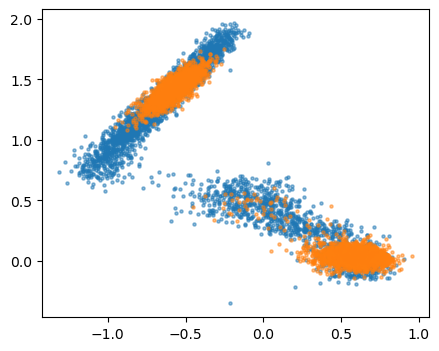

In [38]:

from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files

n_states = 2

# load unlabeled data
filenames = ['data/muller-brown/biased/opes-y/COLVAR']
unsupervised_dataset, unsupervised_df = create_dataset_from_files(filenames, return_dataframe=True, filter_args={'regex':'p.x|p.y'}, verbose=False, start=1000, stop=5000, create_labels=False)

# load labeled data
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]
supervised_dataset, supervised_df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, start=0, stop=2000, verbose=False)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[unsupervised_dataset, supervised_dataset])
print(datamodule)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(unsupervised_df['p.x'], unsupervised_df['p.y'], s=5, alpha=0.5)
ax.scatter(supervised_df['p.x'], supervised_df['p.y'], s=5, alpha=0.5)
plt.show()

## Introduction
In the context of data-driven CVs, multi-task learning is often employed by optimizing different objective functions on the same dataset. In `mlcolvar`, we extended this concept and implemented a framework to perform this on multiple dataset of different type. This allows to train CVs that satisfy multiple requirements and to design methods that can fully exploit all the data we have access to.

In this tutorial, we will show how to setup a multi-task learned CV by taking as an example a semi-supervised learning scenario.

## Setup
The tool for building multi-task learned CVs in `mlcolvar` is the `MultiTaskCV` class

In [52]:
# IMPORT PACKAGES
import torch
import lightning
import numpy as np
import matplotlib.pyplot as plt

# IMPORT HELPER FUNCTIONS
from mlcolvar.cvs import MultiTaskCV, AutoEncoderCV
from mlcolvar.core.loss import TDALoss
from mlcolvar.core.transform.utils import Statistics
from mlcolvar.utils.plot import muller_brown_potential, plot_isolines_2D, plot_metrics
from mlcolvar.utils.trainer import MetricsCallback

# Set seed for reproducibility
torch.manual_seed(42)

## Load data: unlabeled + labeled data
We will use the two-state Muller-Brown potential as example using `p.x` and `p.y` as descriptors.
As datasets, will use:
- **unlabeled dataset** for the unsupervised component of the training obtained from high temperature simualtions
- **labeled dataset** for the supervised component based on unbiased simulations performed in the metastable basins. 

The multiple datasets can be directly passed as list to `DictModule` that will automatically combine them.
The different datasets can be of different size, but the batch_size must be set so that the total number of batches in an epoch is the same for all of them.

DictModule(dataset -> [DictDataset( "data": [5000, 2] ), DictDataset( "data": [4000, 2], "labels": [4000] )],
		     train_loader -> DictLoader(length=0.8, batch_size=2500, shuffle=True),
		     valid_loader -> DictLoader(length=0.2, batch_size=2000, shuffle=True))


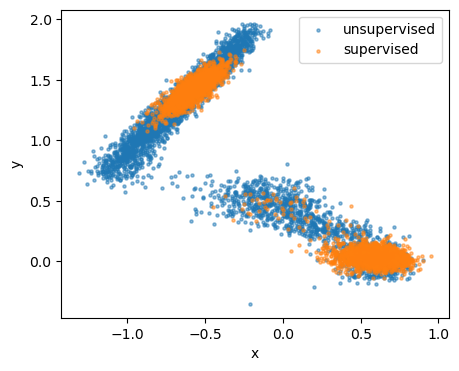

In [84]:
from mlcolvar.data import DictModule
from mlcolvar.utils.io import create_dataset_from_files

n_states = 2

# load unlabeled data
filenames = ['data/muller-brown/biased/opes-y/COLVAR']
unsupervised_dataset, unsupervised_df = create_dataset_from_files(filenames, return_dataframe=True, filter_args={'regex':'p.x|p.y'}, verbose=False, start=0, stop=5000, create_labels=False)

# load labeled data
filenames = [ f"data/muller-brown/unbiased/state-{i}/COLVAR" for i in range(n_states) ]
supervised_dataset, supervised_df = create_dataset_from_files(filenames,return_dataframe=True, filter_args={'regex':'p.x|p.y'}, start=0, stop=2000, verbose=False)

# create multitask datamodule with both datasets
datamodule = DictModule(dataset=[unsupervised_dataset, supervised_dataset], batch_size=[2500, 2000])
print(datamodule)

fig, ax = plt.subplots(figsize=(5,4))
ax.scatter(unsupervised_df['p.x'], unsupervised_df['p.y'], s=5, alpha=0.5, label='unsupervised')
ax.scatter(supervised_df['p.x'], supervised_df['p.y'], s=5, alpha=0.5, label='supervised')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.show()

### Define model

In [54]:
n_descriptors = 2
n_components = 1

nn_args = {'activation': 'shifted_softplus'}
options= {'encoder': nn_args, 'decoder': nn_args }
main_cv = AutoEncoderCV(encoder_layers=[n_descriptors, 32, 16, n_components], options=options)

aux_loss_fn = TDALoss(n_states, [-10, 10], [0.2, 0.2])

model = MultiTaskCV(main_cv, auxiliary_loss_fns=[aux_loss_fn], loss_coefficients=[2])
stat = Statistics()
stat(unsupervised_dataset['data'])
stat(supervised_dataset['data']) 
model.norm_in.set_from_stats(stat)

### Define trainer and fit

In [55]:
# define callbacks
metrics = MetricsCallback()
# define trainer
trainer = lightning.Trainer(callbacks=[metrics], max_epochs=500,
                    enable_checkpointing=False, enable_model_summary=False)
# fit
trainer.fit( model, datamodule )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 47.64it/s, v_num=14]          

`Trainer.fit` stopped: `max_epochs=500` reached.


Epoch 499: 100%|██████████| 1/1 [00:00<00:00, 44.77it/s, v_num=14]


<AxesSubplot:title={'center':'Learning curves'}, xlabel='Epoch', ylabel='Loss'>

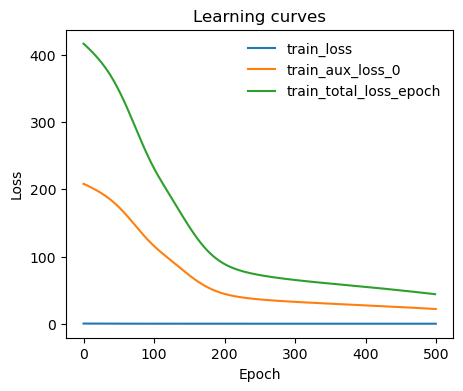

In [56]:
metrics.metrics.keys()  
plot_metrics(metrics.metrics, ['train_loss', 'train_aux_loss_0', 'train_total_loss_epoch'])

### Analysis of the CV

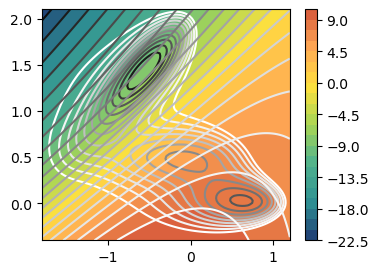

In [57]:
fig,axs = plt.subplots( 1, n_components, figsize=(4*n_components,3) )
if n_components == 1:
    axs = [axs]
for i in range(n_components):
    ax = axs[i]
    plot_isolines_2D(muller_brown_potential,levels=np.linspace(0,24,12),mode='contour',ax=ax)
    plot_isolines_2D(model, component=i, levels=25, ax=ax)
    plot_isolines_2D(model, component=i, mode='contour', levels=25, ax=ax)

#plt.savefig(f'{RESULTS_FOLDER}/cv_isolines.png')
plt.show()

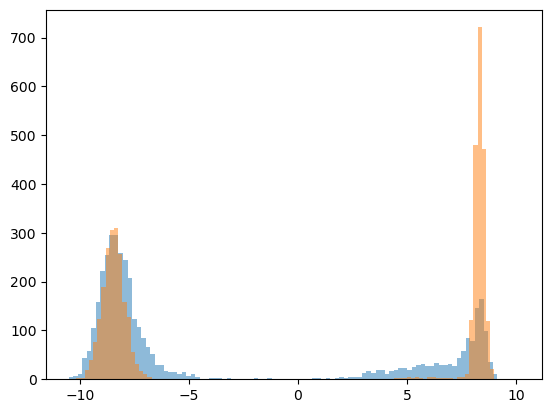

In [58]:
with torch.no_grad():
    plt.hist(model(unsupervised_dataset['data']).numpy(),bins=100, alpha=0.5)
    plt.hist(model(supervised_dataset['data']).numpy(),bins=100, alpha=0.5)
